In [2]:
from src.modeling.solver.metrics import classification_metrics
import hydra
import torch
from src.tools.notebook_helpers import *
from src.tools.convert_logits import relu_evidence
from src.data.build_dataloader import build_dataloader

experiment_dir = r"dataloader_config.batch_size=512,feature_config.normalization_scheme=raw,loss_config=EDLLoss,model_config=bin_tabl,train_config.n_epoch=200"
config_dir = ".hydra"
temp_dir = "D:/uncertainty_sharpe/evidential_deep_learning/output/experiments/main" + "/" + \
           experiment_dir

logit_converter = relu_evidence

In [3]:
with hydra.initialize_config_dir(version_base="1.1", config_dir=temp_dir + "/" + config_dir):
    cfg = hydra.compose(config_name='config')

    n_val_fold = cfg.data_config.nb_validation_fold
    device = torch.device(cfg.train_config.device)

    for val_id in range(n_val_fold):
        model_dir = "model/val_" + str(val_id)

        model, epoch_idx = load_last_model(cfg, temp_dir, model_dir)
        model.eval()

        train_loader, val_loader = build_dataloader(cfg, val_id)
        print_class_percentage(train_loader=train_loader,val_loader=val_loader, val_id=val_id)


Train loader 0: tensor([0.5742, 0.4258]) | Validation loader 0: tensor([0.5517, 0.4483])
Train loader 1: tensor([0.5727, 0.4273]) | Validation loader 1: tensor([0.5274, 0.4726])
Train loader 2: tensor([0.5702, 0.4298]) | Validation loader 2: tensor([0.5193, 0.4807])
Train loader 3: tensor([0.5675, 0.4325]) | Validation loader 3: tensor([0.5326, 0.4674])


In [12]:
from src.tools.notebook_helpers import other_predictor_sharpe

with hydra.initialize_config_dir(version_base="1.1", config_dir=temp_dir + "/" + config_dir):
    cfg = hydra.compose(config_name='config')

    n_val_fold = cfg.data_config.nb_validation_fold
    trans_rate = cfg.train_config.trans_rate
    device = torch.device(cfg.train_config.device)

    for val_id in range(n_val_fold):
        model_dir = "model/val_" + str(val_id)

        model, epoch_idx = load_last_model(cfg, temp_dir, model_dir)
        model.eval()

        train_loader, val_loader = build_dataloader(cfg, val_id)

        evidence_train, target_train, future_return_train, logit_train = forward(model, train_loader, logit_converter, device)
        evidence_test, target_test, future_return_test, logit_test = forward(model, val_loader, logit_converter, device)

        truth_train = torch.argmax(future_return_train, dim=1, keepdim=True)
        truth_test = torch.argmax(future_return_test, dim=1, keepdim=True)

        other_predictor_sharpe(pred_class=truth_train, future_return=future_return_train,
                               trans_rate=trans_rate, val_id=val_id, is_train=True)
        other_predictor_sharpe(pred_class=truth_test, future_return=future_return_test,
                               trans_rate=trans_rate, val_id=val_id, is_train=False)

    print("----------------------------------------------------------------------------")

    for val_id in range(n_val_fold):
        model_dir = "model/val_" + str(val_id)

        model, epoch_idx = load_last_model(cfg, temp_dir, model_dir)
        model.eval()

        train_loader, val_loader = build_dataloader(cfg, val_id)

        evidence_train, target_train, future_return_train, logit_train = forward(model, train_loader, logit_converter, device)
        evidence_test, target_test, future_return_test, logit_test = forward(model, val_loader, logit_converter, device)

        pred_random_train = torch.randint(0, 2, (future_return_train.shape[0], 1)).to(device)
        pred_random_test = torch.randint(0, 2, (future_return_test.shape[0], 1)).to(device)

        other_predictor_sharpe(pred_class=pred_random_train, future_return=future_return_train,
                               trans_rate=trans_rate, val_id=val_id, is_train=True)
        other_predictor_sharpe(pred_class=pred_random_test, future_return=future_return_test,
                               trans_rate=trans_rate, val_id=val_id, is_train=False)


Train loader 0 | Sharpe ratio: 0.4777 | Expected return: 0.0040 | Standard deviation: 0.0084
Val loader 0 | Sharpe ratio: 0.6376 | Expected return: 0.0036 | Standard deviation: 0.0056
Train loader 1 | Sharpe ratio: 0.4832 | Expected return: 0.0040 | Standard deviation: 0.0083
Val loader 1 | Sharpe ratio: 0.5278 | Expected return: 0.0033 | Standard deviation: 0.0062
Train loader 2 | Sharpe ratio: 0.4841 | Expected return: 0.0040 | Standard deviation: 0.0082
Val loader 2 | Sharpe ratio: 0.6084 | Expected return: 0.0031 | Standard deviation: 0.0051
Train loader 3 | Sharpe ratio: 0.4845 | Expected return: 0.0039 | Standard deviation: 0.0081
Val loader 3 | Sharpe ratio: 0.5161 | Expected return: 0.0027 | Standard deviation: 0.0053
----------------------------------------------------------------------------
Train loader 0 | Sharpe ratio: -0.1483 | Expected return: -0.0015 | Standard deviation: 0.0101
Val loader 0 | Sharpe ratio: -0.2259 | Expected return: -0.0017 | Standard deviation: 0.0076

In [5]:
metrics_func = {
    "Squared Error Bayes Risk": classification_metrics.squared_error_bayes_risk,
    "KL Divergence": classification_metrics.kl_divergence_loss,
    "EDL Loss": classification_metrics.edl_loss,
    "Mean Evidence Success": classification_metrics.mean_evidence_succ,
    "Mean Evidence Fail": classification_metrics.mean_evidence_fail,
    "Mean Uncertainty Success": classification_metrics.mean_uncertainty_succ,
    "Mean Uncertainty Fail": classification_metrics.mean_uncertainty_fail,
    "Accuracy": classification_metrics.accuracy
}

with hydra.initialize_config_dir(version_base="1.1", config_dir=temp_dir + "/" + config_dir):
    cfg = hydra.compose(config_name='config')

    n_val_fold = cfg.data_config.nb_validation_fold
    device = torch.device(cfg.train_config.device)

    for val_id in range(n_val_fold):
        model_dir = "model/val_" + str(val_id)

        model, epoch_idx = load_last_model(cfg, temp_dir, model_dir)
        model.eval()

        train_loader, val_loader = build_dataloader(cfg, val_id)

        evidence_train, target_train, future_return_train, logit_train = forward(model, train_loader, logit_converter, device)
        evidence_test, target_test, future_return_test, logit_test = forward(model, val_loader, logit_converter, device)

        compute_performance(evidence=evidence_train, target=target_train, future_return=future_return_train,
                            logit=logit_train, val_id=val_id, metrics_func=metrics_func, epoch_idx=epoch_idx,
                            annealing_step=cfg.loss_config.annealing_step, is_train=True, device=device)

        compute_performance(evidence=evidence_test, target=target_test, future_return=future_return_test,
                            logit=logit_test, val_id=val_id, metrics_func=metrics_func, epoch_idx=epoch_idx,
                            annealing_step=cfg.loss_config.annealing_step, is_train=False, device=device)

Fold: 0| Train Squared Error Bayes Risk: 0.4977| Train KL Divergence: 0.0355| Train EDL Loss: 0.5331| Train Mean Evidence Success: 1.5766| Train Mean Evidence Fail: 0.6998| Train Mean Uncertainty Success: 0.6576| Train Mean Uncertainty Fail: 0.7844| Train Accuracy: 0.7156
Fold: 0| Val Squared Error Bayes Risk: 0.4864| Val KL Divergence: 0.0284| Val EDL Loss: 0.5148| Val Mean Evidence Success: 1.4554| Val Mean Evidence Fail: 0.6302| Val Mean Uncertainty Success: 0.6712| Val Mean Uncertainty Fail: 0.7986| Val Accuracy: 0.7432
Fold: 1| Train Squared Error Bayes Risk: 0.4740| Train KL Divergence: 0.0531| Train EDL Loss: 0.5270| Train Mean Evidence Success: 2.1176| Train Mean Evidence Fail: 1.0067| Train Mean Uncertainty Success: 0.5876| Train Mean Uncertainty Fail: 0.7181| Train Accuracy: 0.7203
Fold: 1| Val Squared Error Bayes Risk: 0.4644| Val KL Divergence: 0.0477| Val EDL Loss: 0.5121| Val Mean Evidence Success: 2.2058| Val Mean Evidence Fail: 0.9821| Val Mean Uncertainty Success: 0.59

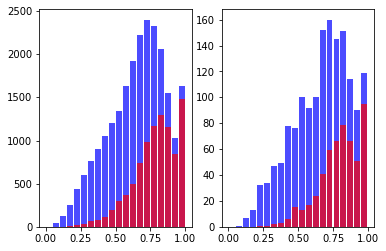

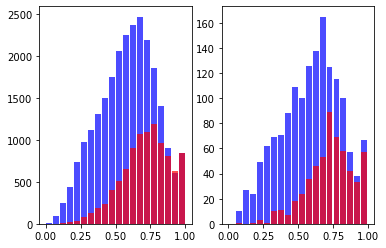

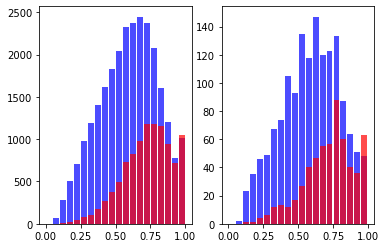

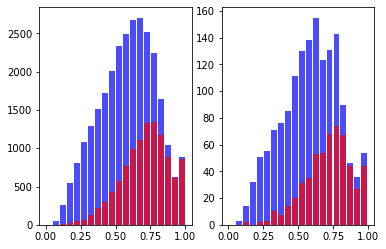

In [6]:
with hydra.initialize_config_dir(version_base="1.1", config_dir=temp_dir + "/" + config_dir):
    cfg = hydra.compose(config_name='config')

    n_val_fold = cfg.data_config.nb_validation_fold
    device = torch.device(cfg.train_config.device)

    for val_id in range(n_val_fold):
        model_dir = "model/val_" + str(val_id)

        model, epoch_idx = load_last_model(cfg, temp_dir, model_dir)
        model.eval()

        train_loader, val_loader = build_dataloader(cfg, val_id)

        evidence_train, target_train, future_return_train, logit_train = forward(model, train_loader, logit_converter, device)
        evidence_test, target_test, future_return_test, logit_test = forward(model, val_loader, logit_converter, device)
        histogram_uncertainty(evidence_train, target_train, evidence_test, target_test)

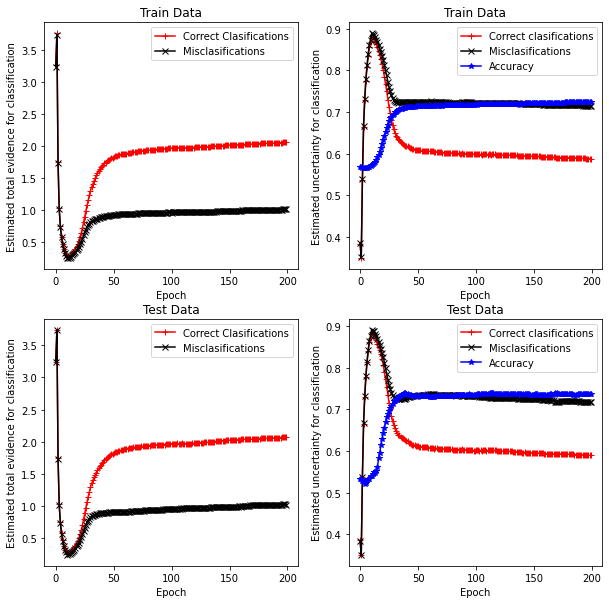

In [7]:
import pylab as pl
import numpy as np

with hydra.initialize_config_dir(version_base="1.1", config_dir=temp_dir + "/" + config_dir):
    cfg = hydra.compose(config_name='config')

    n_val_fold = cfg.data_config.nb_validation_fold
    device = torch.device(cfg.train_config.device)

    checkpoint_files = [os.path.join(temp_dir + "/" + model_dir, f) for f in os.listdir(temp_dir + "/" + model_dir)
                        if f.startswith('checkpoint_')]

    metrics_name = ['Accuracy', 'Mean Evidence Success', 'Mean Evidence Fail',
                    'Mean Uncertainty Success', 'Mean Uncertainty Fail']

    metrics_dict = {}

    for filename in checkpoint_files:
        fid = open(filename, 'rb')
        checkpoint = pickle.load(fid)
        fid.close()

        for name in ['train', 'val']:
            for metric_name in metrics_name:
                if name + "_" + metric_name not in metrics_dict:
                    metrics_dict[name + "_" + metric_name] = []

                metric_value = checkpoint['metric_values'][name + '_' + metric_name][-1]
                metrics_dict[name + "_" + metric_name].append(metric_value)

    for name in ['train', 'val']:
        for metric_name in metrics_name:
            metrics_dict[name + "_" + metric_name] = np.asarray(metrics_dict[name + "_" + metric_name])

    f, axs = pl.subplots(2, 2)
    f.set_size_inches([10, 10])

    axs[0, 0].plot(metrics_dict['train_' + 'Mean Evidence Success'], c='r', marker='+')
    axs[0, 0].plot(metrics_dict['train_' + 'Mean Evidence Fail'], c='k', marker='x')
    axs[0, 0].set_title('Train Data')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Estimated total evidence for classification')
    axs[0, 0].legend(['Correct Clasifications', 'Misclasifications'])

    axs[0, 1].plot(metrics_dict['train_' + 'Mean Uncertainty Success'], c='r', marker='+')
    axs[0, 1].plot(metrics_dict['train_' + 'Mean Uncertainty Fail'], c='k', marker='x')
    axs[0, 1].plot(metrics_dict['train_' + 'Accuracy'], c='blue', marker='*')
    axs[0, 1].set_title('Train Data')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Estimated uncertainty for classification')
    axs[0, 1].legend(['Correct clasifications', 'Misclasifications', 'Accuracy'])

    axs[1, 0].plot(metrics_dict['val_' + 'Mean Evidence Success'], c='r', marker='+')
    axs[1, 0].plot(metrics_dict['val_' + 'Mean Evidence Fail'], c='k', marker='x')
    axs[1, 0].set_title('Test Data')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Estimated total evidence for classification')
    axs[1, 0].legend(['Correct Clasifications', 'Misclasifications'])

    axs[1, 1].plot(metrics_dict['val_' + 'Mean Uncertainty Success'], c='r', marker='+')
    axs[1, 1].plot(metrics_dict['val_' + 'Mean Uncertainty Fail'], c='k', marker='x')
    axs[1, 1].plot(metrics_dict['val_' + 'Accuracy'], c='blue', marker='*')
    axs[1, 1].set_title('Test Data')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Estimated uncertainty for classification')
    axs[1, 1].legend(['Correct clasifications', 'Misclasifications', 'Accuracy'])

    plt.show()